In [240]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
# from linearmodels.panel.data import PanelData
# from linearmodels.panel import PanelOLS, PooledOLS, RandomEffects, compare
import matplotlib.pyplot as plt
import pyblp

In [241]:
drop_otc,drop_sotc=1,0
product_data=pd.read_csv("../../data/merged/len3_ndb_blp_DN_firm_FC.csv",encoding="utf-8",index_col=0)
print(product_data.columns[:30])
product_data=product_data.rename(columns={"薬価":"prices",
                    # "lag_mean_price":"demand_instruments0",
                    # "lag_sum_quantity":"demand_instruments1",
                    # "lag_generic_share_q":"demand_instruments2",
                    "同一剤形・規格の後発医薬品がある先発医薬品":"long_run",
                    "後発品区分":"generic"})
# "long_run"列の欠損値を0で埋める
product_data["long_run"].fillna(0, inplace=True)

# "long_run"列の"○"を1に置き換える
product_data["long_run"] = product_data["long_run"].replace("○", 1)
product_data.loc[product_data["メーカー名"]=="sotc","prices"]=product_data.loc[product_data["メーカー名"]=="sotc","mean_price_g"]
# "year"列でフィルタリング
product_data = product_data[product_data["year"] > 2014]
if drop_otc:
    product_data = product_data[product_data["メーカー名"]!="otc"]
if drop_sotc:
    product_data = product_data[product_data["メーカー名"]!="sotc"]


Index(['薬効分類', '薬効分類名称', '医薬品コード', '医薬品名', '薬価基準収載医薬品コード', '薬価', '後発品区分', '総計',
       'year', 'in_hospital', 'oral', 'id_l4', 'Approved', 'KEGG',
       'Ingredient', 'date', 'release_year', '成分', 'variable', 'id_x',
       'revenue', 'elapsed', 'elapsed_m6', 'elapsed_m5', 'elapsed_m4',
       'elapsed_m3', 'elapsed_m2', 'elapsed_m1', 'elapsed_0', 'elapsed_1'],
      dtype='object')


C:\Users\hakos\AppData\Local\Temp\ipykernel_38712\2118006142.py:2: DtypeWarning: Columns (118) have mixed types. Specify dtype option on import or set low_memory=False.
  product_data=pd.read_csv("../../data/merged/len3_ndb_blp_DN_firm_FC.csv",encoding="utf-8",index_col=0)


In [242]:
save=0
product_data.loc[:,"market_ids"]=product_data.loc[:,"薬効分類"].astype(int).astype(str)+"-"+product_data.loc[:,"year"].astype(int).astype(str)
product_data.loc[:,"firm_ids"]=product_data.loc[:,"メーカー名"].astype(str)
product_data.loc[:,"shares"]=product_data["総計"]/(120000000*100)
product_data.loc[:,"Pharmacopoeia"]=product_data["局方"].replace("局",1).fillna(0)
# print(product_data["Pharmacopoeia"].value_counts())

# drop which doesn't have generic
# product_data=product_data[~((product_data["long_run"]==0)&(zproduct_data["generic"]==0))]
product_data=product_data.loc[product_data["shares"]>0]

product_data=product_data[["market_ids","firm_ids","prices","oral","generic","in_hospital","薬効分類","year","shares","id_l4","long_run","otc","Pharmacopoeia"]]
product_data=product_data.astype({"prices":float,"shares":float,"oral":float,"generic":int,"otc":int,"in_hospital":int,"long_run":int})

product_data.reset_index(drop=True,inplace=True)
print(product_data.columns[:20])
print(product_data.shape)

Index(['market_ids', 'firm_ids', 'prices', 'oral', 'generic', 'in_hospital',
       '薬効分類', 'year', 'shares', 'id_l4', 'long_run', 'otc', 'Pharmacopoeia'],
      dtype='object')
(24561, 13)


In [243]:
# product_data["long_run"].value_counts()
# product_data["lag_sum_quantity"].isna().sum()
# product_data.shape


In [244]:
demand_instruments=pyblp.build_blp_instruments(pyblp.Formulation("1+generic+oral+long_run+Pharmacopoeia"),product_data=product_data)
# demand_instruments=pyblp.build_blp_instruments(formulation=pyblp.Formulation("1+prices+generic+oral+in_hospital"),product_data=product_data)
demand_instruments
demand_instruments.shape,product_data.shape

((24561, 10), (24561, 13))

In [245]:
MD=demand_instruments.shape[1]
demand_instruments=pd.DataFrame(demand_instruments, columns=[f'demand_instruments{i}' for i in range(MD)])
product_data=pd.concat([product_data,demand_instruments],axis=1)
product_data.columns,product_data.shape

(Index(['market_ids', 'firm_ids', 'prices', 'oral', 'generic', 'in_hospital',
        '薬効分類', 'year', 'shares', 'id_l4', 'long_run', 'otc', 'Pharmacopoeia',
        'demand_instruments0', 'demand_instruments1', 'demand_instruments2',
        'demand_instruments3', 'demand_instruments4', 'demand_instruments5',
        'demand_instruments6', 'demand_instruments7', 'demand_instruments8',
        'demand_instruments9'],
       dtype='object'),
 (24561, 23))

In [246]:
# lagged demand instruments
# demand_instrument_columns = [col for col in product_data.columns if col.startswith('demand_instrument')]
# def lag_demand_instruments(group):
#     for col in demand_instrument_columns:
#         for i in range(N_DI):  # 0から1までのラグを取得
#             lagged_column_name = f'demand_instruments{i+N_DI}'
#             group[lagged_column_name] = group[col].shift(1)
#     return group
# product_data=product_data.sort_values(['薬効分類', 'year'])
# product_data = product_data.groupby('id_l4').apply(lag_demand_instruments)
# product_data.shape

product_data.shape
product_data.columns[:30]

Index(['market_ids', 'firm_ids', 'prices', 'oral', 'generic', 'in_hospital',
       '薬効分類', 'year', 'shares', 'id_l4', 'long_run', 'otc', 'Pharmacopoeia',
       'demand_instruments0', 'demand_instruments1', 'demand_instruments2',
       'demand_instruments3', 'demand_instruments4', 'demand_instruments5',
       'demand_instruments6', 'demand_instruments7', 'demand_instruments8',
       'demand_instruments9'],
      dtype='object')

In [247]:
product_data["nesting_ids"]=product_data["oral"].astype(int).astype(str)+product_data["otc"].astype(int).astype(str)
logit_formulation= pyblp.Formulation('1+prices+oral+in_hospital+generic+long_run+otc+Pharmacopoeia', absorb='C(market_ids)+C(firm_ids)')
if drop_sotc and drop_otc:
    logit_formulation= pyblp.Formulation('1+prices+oral+in_hospital+generic+long_run+Pharmacopoeia', absorb='C(market_ids)+C(firm_ids)')
# logit_formulation= pyblp.Formulation('prices+oral+in_hospital+long_run', absorb='C(market_ids)+C(firm_ids)')
logit_formulation
# product_data["shares"]-=1e-10
# typeで怒られがち
problem = pyblp.Problem(product_formulations=logit_formulation, product_data=product_data)
# problem
optimization=pyblp.Optimization('bfgs')
logit_results = problem.solve(rho=0.7, optimization=optimization)
logit_results

Initializing the problem ...
Absorbing demand-side fixed effects ...


Detected collinearity issues with [otc] and at least one other column in X1. Absorbed fixed effects may be creating collinearity problems. To disable collinearity checks, set options.collinear_atol = options.collinear_rtol = 0.
Detected collinearity issues with [demand_instruments5, oral, generic, long_run, otc, Pharmacopoeia] and at least one other column in ZD. Absorbed fixed effects may be creating collinearity problems. To disable collinearity checks, set options.collinear_atol = options.collinear_rtol = 0.
Detected that the 2SLS weighting matrix is nearly singular with condition number +4.319882E+27. To disable singularity checks, set options.singular_tol = numpy.inf.


Initialized the problem after 00:00:01.

Dimensions:
 T     N     F    K1    MD    ED    H 
---  -----  ---  ----  ----  ----  ---
175  24561  190   7     16    2     4 

Formulations:
     Column Indices:          0      1         2          3        4       5         6      
--------------------------  ------  ----  -----------  -------  --------  ---  -------------
X1: Linear Characteristics  prices  oral  in_hospital  generic  long_run  otc  Pharmacopoeia
Solving the problem ...

Rho Initial Values:
 All Groups  
-------------
+7.000000E-01
Starting optimization ...

GMM   Computation  Optimization   Objective   Fixed Point  Contraction  Clipped    Objective      Objective      Gradient                  
Step     Time       Iterations   Evaluations  Iterations   Evaluations  Shares       Value       Improvement       Norm           Theta    
----  -----------  ------------  -----------  -----------  -----------  -------  -------------  -------------  -------------  -------------
 1

Detected that the estimated covariance matrix of aggregate GMM moments is nearly singular with condition number +3.540958E+27. To disable singularity checks, set options.singular_tol = numpy.inf.


Computed results after 00:00:03.

Problem Results Summary:
GMM     Objective      Gradient                    Clipped  Weighting Matrix
Step      Value          Norm          Hessian     Shares   Condition Number
----  -------------  -------------  -------------  -------  ----------------
 1    +2.971964E+01  +3.430620E+01  +1.348890E+09     0      +9.055541E+26  

Starting optimization ...

GMM   Computation  Optimization   Objective   Fixed Point  Contraction  Clipped    Objective      Objective      Gradient                  
Step     Time       Iterations   Evaluations  Iterations   Evaluations  Shares       Value       Improvement       Norm           Theta    
----  -----------  ------------  -----------  -----------  -----------  -------  -------------  -------------  -------------  -------------
 2     00:00:01         0             1            0            0          0     +7.091347E+01                 +7.009762E+01  +7.000000E-01
 2     00:00:01         0             2      

Detected that the estimated covariance matrix of aggregate GMM moments is nearly singular with condition number +2.589672E+27. To disable singularity checks, set options.singular_tol = numpy.inf.
Detected that the estimated covariance matrix of aggregate GMM moments is nearly singular with condition number +2.593338E+27. To disable singularity checks, set options.singular_tol = numpy.inf.


Problem Results Summary:
GMM     Objective      Gradient                    Clipped  Weighting Matrix  Covariance Matrix
Step      Value          Norm          Hessian     Shares   Condition Number  Condition Number 
----  -------------  -------------  -------------  -------  ----------------  -----------------
 2    +5.356861E+01  +2.404287E-08  +1.416466E+02     0      +2.497990E+41      +9.801703E+36  

Cumulative Statistics:
Computation  Optimizer  Optimization   Objective 
   Time      Converged   Iterations   Evaluations
-----------  ---------  ------------  -----------
 00:00:54       No           2            67     

Rho Estimates (Robust SEs in Parentheses):
  All Groups   
---------------
 +1.194877E+00 
(+1.006169E-01)

Beta Estimates (Robust SEs in Parentheses):
    prices            oral          in_hospital        generic         long_run            otc         Pharmacopoeia 
---------------  ---------------  ---------------  ---------------  ---------------  -----------

In [248]:
# print(np.round(logit_results.beta.T/(1-logit_results.rho),4))
# print(np.round(logit_results.beta_se.T,6))
data = np.vstack((logit_results.beta.T/(1-logit_results.rho),
logit_results.beta_se.T))

# Find the maximum width for each column
max_widths = [max(len(f"{num:.4f}") for num in col) for col in zip(*data)]

# Format and print the aligned data
for row in data:
    formatted_row = [f"{num:.4f}".rjust(max_width) for num, max_width in zip(row, max_widths)]
    print(" ".join(formatted_row))

-0.0002 -11.3332 0.4973 -0.1456 0.5863 0.0000 -0.8108
 0.0001   0.0466 0.0483  0.0309 0.0378 0.0000  0.0094


In [249]:
instruments_results=logit_results.compute_optimal_instruments()
instruments_results

Computing optimal instruments for theta ...
Computed optimal instruments after 00:00:01.

Optimal Instrument Results Summary:
Computation  Error Term
   Time        Draws   
-----------  ----------
 00:00:01        1     


Optimal Instrument Results Summary:
Computation  Error Term
   Time        Draws   
-----------  ----------
 00:00:01        1     

In [250]:
updated_problem=instruments_results.to_problem()
updated_results=updated_problem.solve(rho=0.7,optimization=optimization)
updated_results

Re-creating the problem ...
Absorbing demand-side fixed effects ...


Detected collinearity issues with [otc] and at least one other column in X1. Absorbed fixed effects may be creating collinearity problems. To disable collinearity checks, set options.collinear_atol = options.collinear_rtol = 0.
Detected collinearity issues with [otc] and at least one other column in ZD. Absorbed fixed effects may be creating collinearity problems. To disable collinearity checks, set options.collinear_atol = options.collinear_rtol = 0.
Detected that the 2SLS weighting matrix is nearly singular with condition number +6.545904E+31. To disable singularity checks, set options.singular_tol = numpy.inf.


Re-created the problem after 00:00:00.

Dimensions:
 T     N     F    K1    MD    ED    H 
---  -----  ---  ----  ----  ----  ---
175  24561  190   7     8     2     4 

Formulations:
     Column Indices:          0      1         2          3        4       5         6      
--------------------------  ------  ----  -----------  -------  --------  ---  -------------
X1: Linear Characteristics  prices  oral  in_hospital  generic  long_run  otc  Pharmacopoeia
Solving the problem ...

Rho Initial Values:
 All Groups  
-------------
+7.000000E-01
Starting optimization ...

GMM   Computation  Optimization   Objective   Fixed Point  Contraction  Clipped    Objective      Objective      Gradient                  
Step     Time       Iterations   Evaluations  Iterations   Evaluations  Shares       Value       Improvement       Norm           Theta    
----  -----------  ------------  -----------  -----------  -----------  -------  -------------  -------------  -------------  -------------
 1 

Detected that the estimated covariance matrix of aggregate GMM moments is nearly singular with condition number +1.016788E+32. To disable singularity checks, set options.singular_tol = numpy.inf.


Computed results after 00:00:02.

Problem Results Summary:
GMM     Objective      Gradient                    Clipped  Weighting Matrix
Step      Value          Norm          Hessian     Shares   Condition Number
----  -------------  -------------  -------------  -------  ----------------
 1    +1.965480E-06  +3.376234E-07  +5.086390E+01     0          +INF       

Starting optimization ...

GMM   Computation  Optimization   Objective   Fixed Point  Contraction  Clipped    Objective      Objective      Gradient                  
Step     Time       Iterations   Evaluations  Iterations   Evaluations  Shares       Value       Improvement       Norm           Theta    
----  -----------  ------------  -----------  -----------  -----------  -------  -------------  -------------  -------------  -------------
 2     00:00:01         0             1            0            0          0     +5.967925E-10                 +1.611155E-05  -7.450270E+00
 2     00:00:01         0             2      

Detected that the estimated covariance matrix of aggregate GMM moments is nearly singular with condition number +1.016775E+32. To disable singularity checks, set options.singular_tol = numpy.inf.
Detected that the estimated covariance matrix of aggregate GMM moments is nearly singular with condition number +1.016775E+32. To disable singularity checks, set options.singular_tol = numpy.inf.


Problem Results Summary:
GMM     Objective      Gradient                    Clipped  Weighting Matrix  Covariance Matrix
Step      Value          Norm          Hessian     Shares   Condition Number  Condition Number 
----  -------------  -------------  -------------  -------  ----------------  -----------------
 2    +4.751297E-11  +4.546025E-06  +2.174810E-01     0      +2.774150E+32      +4.645719E+38  

Cumulative Statistics:
Computation  Optimizer  Optimization   Objective 
   Time      Converged   Iterations   Evaluations
-----------  ---------  ------------  -----------
 00:00:09       Yes          5             9     

Rho Estimates (Robust SEs in Parentheses):
  All Groups   
---------------
 -7.450217E+00 
(+3.032505E+00)

Beta Estimates (Robust SEs in Parentheses):
    prices            oral          in_hospital        generic         long_run            otc         Pharmacopoeia 
---------------  ---------------  ---------------  ---------------  ---------------  -----------

In [251]:
print(np.round(updated_results.beta.T/(1-updated_results.rho),4))

[[-1.000e-04  4.380e-01  4.733e-01 -2.074e-01  1.986e-01 -0.000e+00
   2.110e-02]]


Computing marginal costs ...
Finished after 00:00:01.



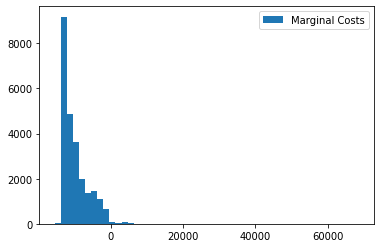

Computing markups ...
Finished after 00:00:00.



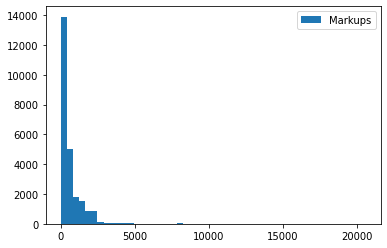

In [252]:
costs = updated_results.compute_costs()
plt.hist(costs, bins=50)
plt.legend(["Marginal Costs"])
plt.show()
markups = updated_results.compute_markups(costs=costs)
plt.hist(markups, bins=50)
plt.legend(["Markups"])

In [253]:
cs=updated_results.compute_consumer_surpluses()
sum(cs),np.mean(cs)

Computing consumer surpluses with the equation that assumes away nonlinear income effects ...
Finished after 00:00:00.



(array([55194.75062668]), 315.3985750095825)

In [254]:
import datetime

# Get the current date and time
current_time = datetime.datetime.now()

# Format the time as a string
time_string = current_time.strftime("%Y-%m-%d_%H-%M-%S")
if save:
    logit_results.to_pickle(f"./results/MNL_len3_{time_string}.pkl")

In [255]:
elasticities = logit_results.compute_elasticities()

Computing elasticities with respect to prices ...
Finished after 00:00:00.



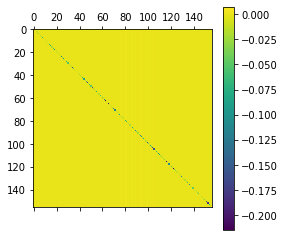

In [256]:
%matplotlib inline
import matplotlib.pyplot as plt
single_market = product_data['market_ids'] == '131-2015'
K=sum(single_market)
plt.colorbar(plt.matshow(elasticities[single_market][:,:K]))

In [257]:
product_data[single_market].shape,K

((156, 24), 156)

In [258]:
elasticities[single_market][:,:K]

array([[-2.89761222e-04,  1.79164018e-03, -3.14042995e-06, ...,
        -1.46427285e-06, -2.39475584e-07, -4.67724511e-09],
       [ 7.43386821e-03, -5.93198925e-03, -3.14042995e-06, ...,
        -1.46427285e-06, -2.39475584e-07, -4.67724511e-09],
       [-2.64408260e-06, -6.37251629e-07, -4.34023501e-03, ...,
         1.02533324e-04,  1.67688881e-05, -4.67724511e-09],
       ...,
       [-2.64408260e-06, -6.37251629e-07,  2.19903498e-04, ...,
        -8.11554330e-02,  1.67688881e-05, -4.67724511e-09],
       [-2.64408260e-06, -6.37251629e-07,  2.19903498e-04, ...,
         1.02533324e-04, -1.42525944e-02, -4.67724511e-09],
       [-2.64408260e-06, -6.37251629e-07, -3.14042995e-06, ...,
        -1.46427285e-06, -2.39475584e-07,  2.48876819e-03]])

Computing diversion ratios with respect to prices ...


Finished after 00:00:00.



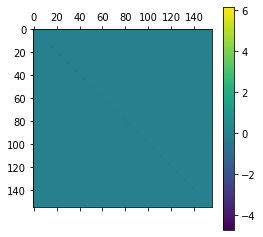

In [259]:
diversions = logit_results.compute_diversion_ratios()
plt.colorbar(plt.matshow(diversions[single_market][:,:K]))